# Code

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# One-timers ("stuff that needs to be done once")

This section will define all functions and parameters, needed for the pipeline. Also, if experiments were necessary, they were laid out in this section

In [2]:
images = glob.glob("./camera_cal/calibration*.jpg")

# array ti store object and images points
# top left (0,0,0), bottom right (7,5,0)

objpoints = [] # 3d points in real world
imgpoints = [] # 2D points in image plane

# prepare oiunts, like (0,0,0), (1,0,0), (2,0,0), ... (7,5,0)
n_x = 9
n_y = 6
objp = np.zeros((n_x*n_y,3), np.float32)
objp[:,:2] = np.mgrid[0:n_x, 0:n_y].T.reshape(-1, 2) # x, y coordinates

for img_name in images:
    # Load image
    img = mpimg.imread(img_name)
    
    # Convert to grayscale image
    grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(grayscale_image, (n_x, n_y), None)

    # if corners are found, add object points, image points
    if ret is True:
        print("appending points for image {}...".format(img_name))
        imgpoints.append(corners)
        objpoints.append(objp) # everytime the same, cause it the "real" chessboard

        # draw n display
        img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
        plt.imshow(img)
    else:
        print("there is an issue with image {}, right number of corners cannot be found".format(img_name))

there is an issue with image ./camera_cal\calibration1.jpg, right number of corners cannot be found
appending points for image ./camera_cal\calibration10.jpg...
appending points for image ./camera_cal\calibration11.jpg...
appending points for image ./camera_cal\calibration12.jpg...
appending points for image ./camera_cal\calibration13.jpg...
appending points for image ./camera_cal\calibration14.jpg...
appending points for image ./camera_cal\calibration15.jpg...
appending points for image ./camera_cal\calibration16.jpg...
appending points for image ./camera_cal\calibration17.jpg...
appending points for image ./camera_cal\calibration18.jpg...
appending points for image ./camera_cal\calibration19.jpg...
appending points for image ./camera_cal\calibration2.jpg...
appending points for image ./camera_cal\calibration20.jpg...
appending points for image ./camera_cal\calibration3.jpg...
there is an issue with image ./camera_cal\calibration4.jpg, right number of corners cannot be found
there is 

In [3]:
img_name = "./camera_cal/calibration2.jpg"
test_img = mpimg.imread(img_name)

# objpoints is our original array of all real points and imgpoints now holds the result of all calibration images
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_img[:,:,2].shape[::-1], None, None)
print("camera calibrated")

camera calibrated


In [4]:
# shorter for future use
def ud(img, my_mtx = mtx, my_dist = dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

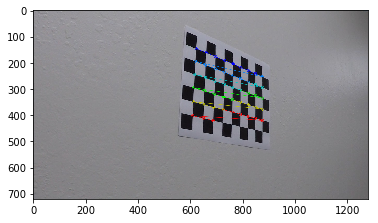

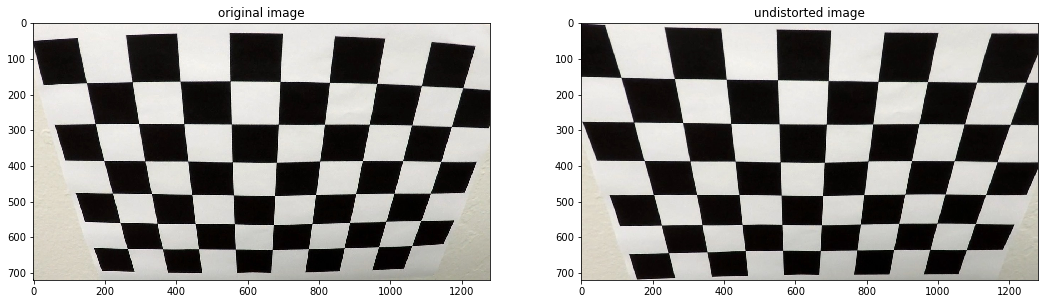

In [5]:
# plot comparision
plt.rcParams['figure.figsize'] = (18, 6)
fig, ax = plt.subplots(nrows=2, ncols=2)

plt.subplot(1, 2, 1) #one row, two col, first plot
img_name = "./camera_cal/calibration2.jpg"
test_img = mpimg.imread(img_name)
plt.imshow(test_img)
plt.title("original image")

plt.subplot(1, 2, 2) #one row, two col, first plot
test_img_udst = ud(test_img)
plt.imshow(test_img_udst)
plt.title("undistorted image")
plt.show()

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('test_images/test5.jpg')

# Edit this function to create your own pipeline.
def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

In [7]:
import numpy as np
import cv2

def warp(img, 
         src = [[0, 720], [573, 450], [707, 450], [1280, 720]], 
         dst = [[0, 720], [0, 0], [1280, 0], [1280, 720]],
         invert=False):
    

    img_size = (img.shape[1], img.shape[0])

    src = np.float32(src)

    dst = np.float32(dst)

    # compute the transformation
    M = cv2.getPerspectiveTransform(src, dst)

    # compute the inverse to reverse the transformation
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #  ---> X
    #  | 1....2
    # \/ ......
    # y  0....3
    #target_dim_x = int(dst[2][0] - dst[0][0])
    #target_dim_y = int(dst[0][1] - dst[1][1])
    #warped = warped[0:target_dim_y, 0:target_dim_x] # Crop from x, y, w, h -> 100, 200, 300, 400

    if invert:
        # get warped image
        return cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR, # INTER_CUBIC
                                   borderMode=cv2.BORDER_CONSTANT, borderValue = [0, 0, 0, 0])
    else:
        return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR, # INTER_CUBIC
                                   borderMode=cv2.BORDER_CONSTANT, borderValue = [0, 0, 0, 0])

The following cell was used to manually evaluate different warping and selection regions. As it turned out, selecting the complete part of the lower image is necessary to catch lanes when the car is close to the edge of the lane

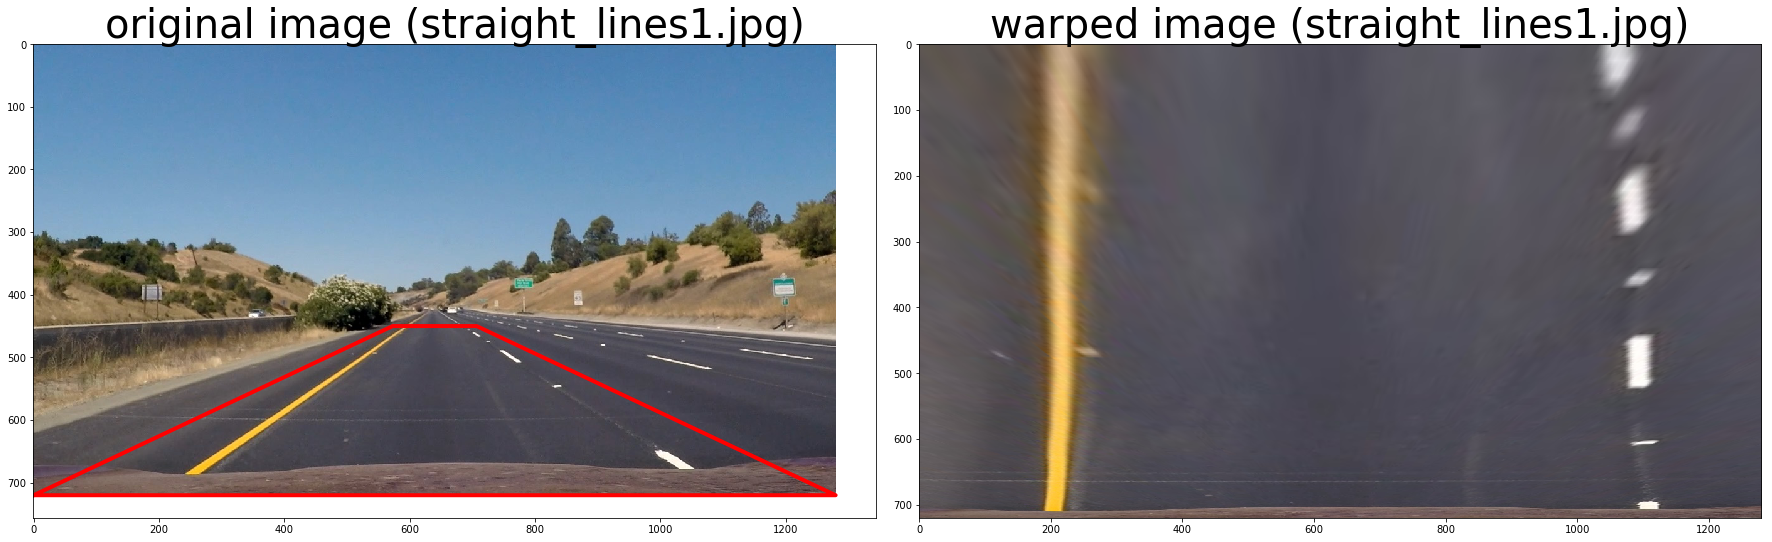

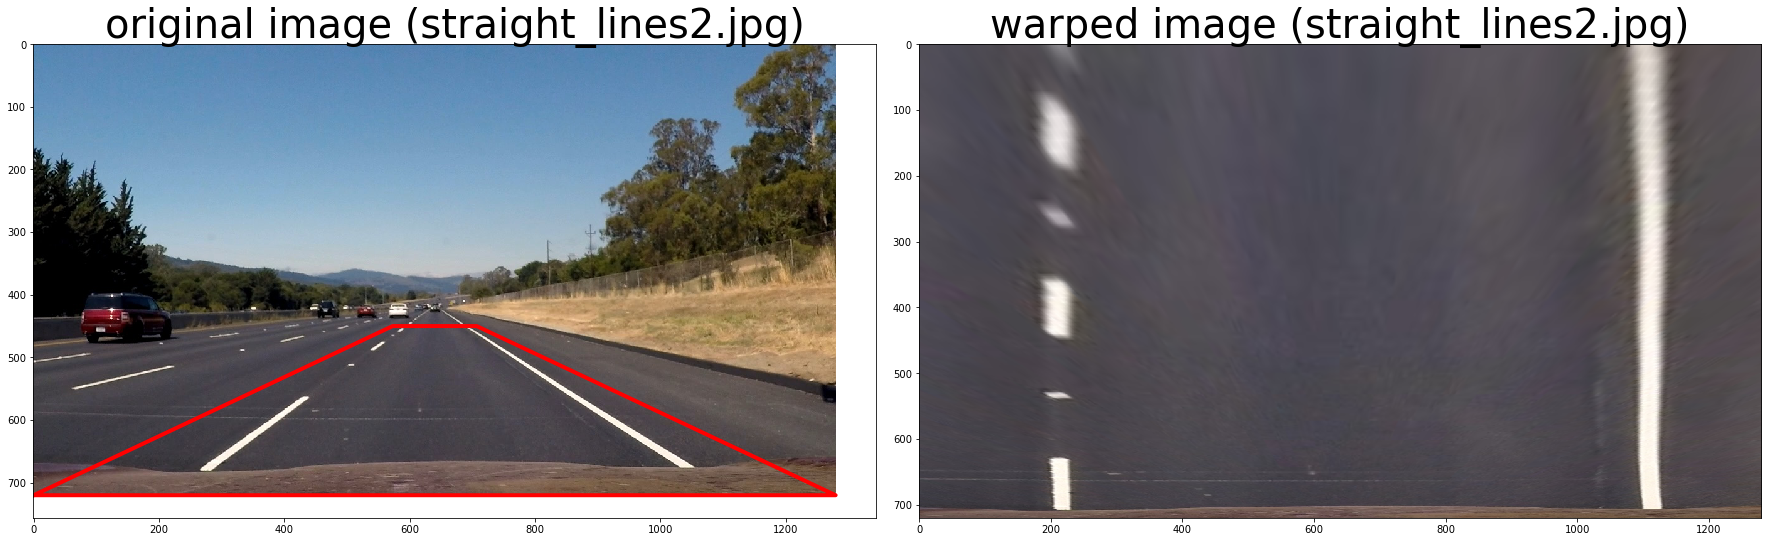

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


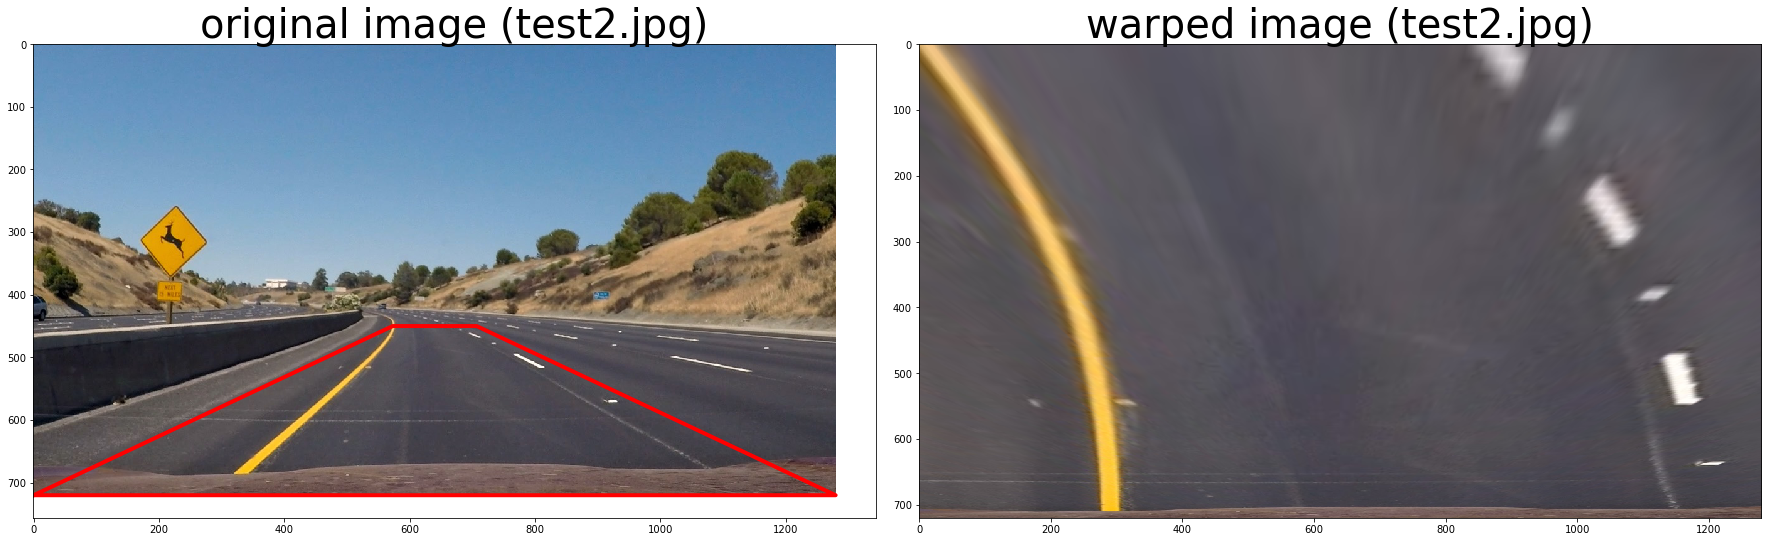

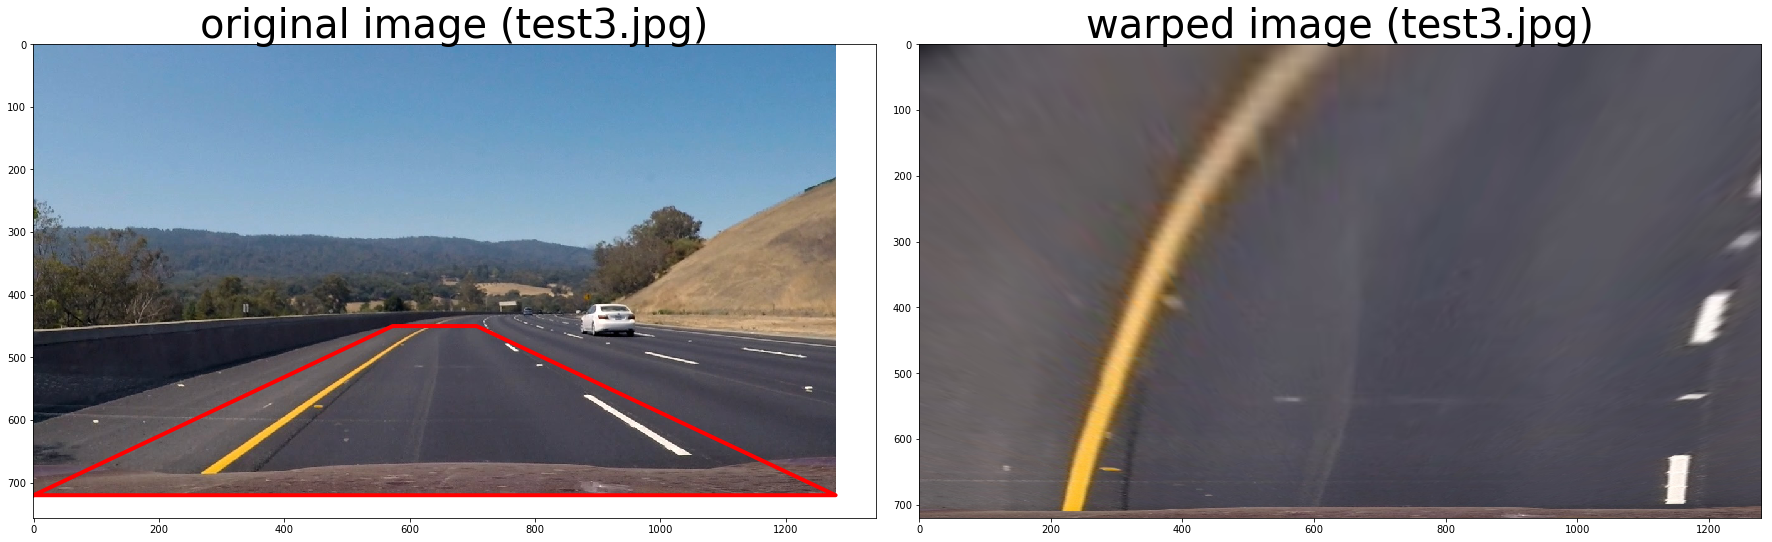

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


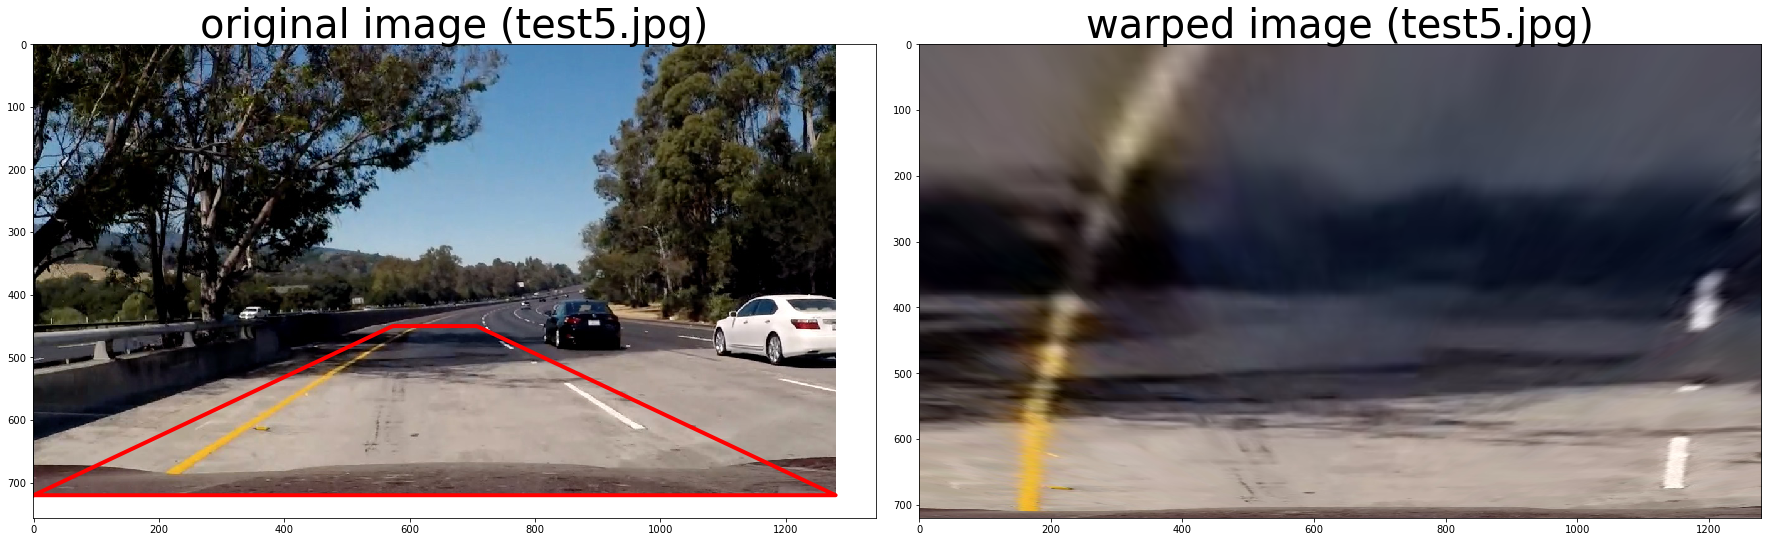

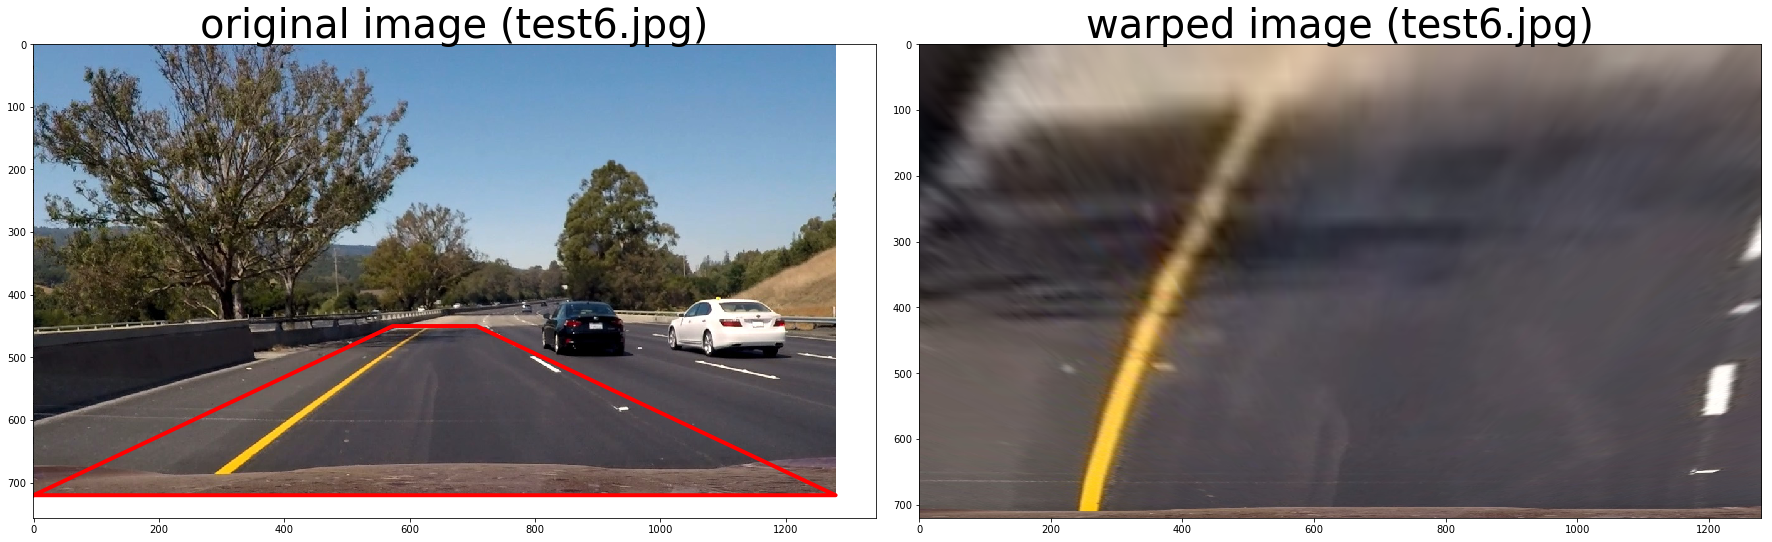

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os

# Read and dispaly the original image
img = mpimg.imread("test_images/straight_lines1.jpg")
im_height, im_width, im_depth = img.shape
distance_x_close = 0  # distance between border of image and polygon
distance_x_far = 573
px_y_close = im_height
px_y_far = 450

# source rectangle
x_plot = [distance_x_close, distance_x_far, im_width - distance_x_far, im_width - distance_x_close]
x_plot.append(x_plot[0])
y_plot = [px_y_close, px_y_far, px_y_far, px_y_close]
y_plot.append(y_plot[0])
src = []
for i, (x, y) in enumerate(zip(x_plot, y_plot)):
    if i > 3:
        # not used for warping, just for visualization
        break
    src.append([x, y])

dst_size_image = distance_x_far
x_dst = [distance_x_close, distance_x_close, im_width - distance_x_close, im_width - distance_x_close]
y_dst = [im_height, 0, 0,  im_height]
dst = []
for (x, y) in zip(x_dst, y_dst):
    dst.append([x, y])

images = glob.glob("test_images/*.jpg")
for pth in images:
    img = mpimg.imread(pth)
    f_name = os.path.basename(pth)
    result = warp(img, src=src, dst = dst)#, img_shape=[dst_size_image, dst_size_image])
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title("original image ({})".format(f_name), fontsize=40)
    ax1.plot(x_plot, y_plot, linewidth=4, color="r")

    ax2.imshow(result, cmap='gray')
    ax2.set_title('warped image ({})'.format(f_name), fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

In [9]:
#sections = 2
#histogram = np.sum(warped_thresholded[warped_thresholded.shape[0]//sections:,:], axis=0)
#plt.plot(histogram)
#plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width = 50, window_height = 80, margin = 80, video_mode=False):
    """
    :param window_height: Break image into 9 vertical layers since image height is 720
    :param margin:  How much to slide left and right for searching, default was 100
    """
    global left_line
    global right_line
    global window_centroids
    global l_sum
    global l_center
    global r_sum
    global r_center
    
    conv_threshold = 5000
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 

    # just for reference: warped.shape yields [720,1280] => first dim is height (as always)

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_conv_signal = np.convolve(window,l_sum)
    if np.sum(l_conv_signal) < conv_threshold*10 and left_line.centroid is not None:
        if not video_mode: print("left: using centroid from last frame {}".format(left_line.centroid))
        l_center = left_line.centroid
        left_line.detected = False
    else:
        l_center = np.argmax(l_conv_signal)-window_width/2
        left_line.detected = True

    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_conv_signal = np.convolve(window,r_sum)
    if np.sum(r_conv_signal) < conv_threshold*10 and right_line.centroid is not None: # first time, in front of car
        # use the center from last iteration
        if not video_mode: print("right: using centroid from last frame {}".format(right_line.centroid))
        r_center = right_line.centroid
        right_line.detected = False
    else:
        r_center = np.argmax(r_conv_signal)-window_width/2+int(warped.shape[1]/2)
        right_line.detected = True
        
    if not video_mode: print("r_conv_signal={}".format(np.sum(r_conv_signal)))
    if not video_mode: print("l_conv_signal={}".format(np.sum(l_conv_signal)))
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    l_last_delta = 0
    r_last_delta = 0
    n_vertical_slices = int(warped.shape[0]/window_height)
    for level in range(1,n_vertical_slices):
        # convolve the window into the vertical slice of the image
        slice_start = int(warped.shape[0]-(level+1)*window_height)
        slice_end = int(warped.shape[0]-level*window_height)
        if not video_mode:
            print("slicing from {} to {}.".format(slice_start, slice_end))

        image_slice = warped[slice_start:slice_end,:]  # get image slice
        image_layer = np.sum(image_slice, axis=0)      # sum slice in y direction, to only get 1x1280 image

        # convole works like this np.convolve([1, 2, 3], [0, 1, 1]) -> array([0, 1, 3, 5, 3])
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(min(max(l_center+offset-margin,0), warped.shape[1]))
        l_max_index = int(max(min(l_center+offset+margin,warped.shape[1]), 0))
        if l_min_index == l_max_index:
            l_min_index = l_max_index - 1
        l_conv_signal = conv_signal[l_min_index:l_max_index]
        if len(l_conv_signal) > 0:
            l_center_new = np.argmax(l_conv_signal)+l_min_index-offset
        else:
            l_center_new = l_center
            
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(min(max(r_center+offset-margin,0), warped.shape[1]))
        r_max_index = int(max(min(r_center+offset+margin,warped.shape[1]), 0))
        if r_min_index == r_max_index:
            r_min_index = r_max_index - 1
        r_conv_signal = conv_signal[r_min_index:r_max_index]
        if len(r_conv_signal) > 0:
            r_center_new = np.argmax(r_conv_signal)+r_min_index-offset
        else:
            r_center_new = r_center
        
        if not video_mode:
            print("conv_left={}, conv_right={}, level={}".format(np.sum(l_conv_signal), np.sum(r_conv_signal), level))
        if (np.sum(l_conv_signal) < conv_threshold):
            l_center = l_center + l_last_delta
        else:
            left_line.trust = level
            l_last_delta = l_center_new - l_center
            l_center = l_center_new

        if (np.sum(r_conv_signal) < conv_threshold):
            r_center = r_center + r_last_delta
        else:
            r_last_delta = r_center_new - r_center
            r_center = r_center_new
            right_line.trust = level

        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        
    left_line.centroid = window_centroids[0][0]
    right_line.centroid = window_centroids[0][1]

    return window_centroids

In [11]:
def blend_transparent(face_img, overlay_t_img):
    # https://stackoverflow.com/questions/40895785/using-opencv-to-overlay-transparent-image-onto-another-image
    # Split out the transparency mask from the colour info
    overlay_img = overlay_t_img[:,:,:3] # Grab the BRG planes
    overlay_mask = overlay_t_img[:,:,3:]  # And the alpha plane

    # Again calculate the inverse mask
    background_mask = 255 - overlay_mask

    # Turn the masks into three channel, so we can use them as weights
    overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
    background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)

    # Create a masked out face image, and masked out overlay
    # We convert the images to floating point in range 0.0 - 1.0
    face_part = (face_img * (1 / 255.0)) * (background_mask * (1 / 255.0))
    overlay_part = (overlay_img * (1 / 255.0)) * (overlay_mask * (1 / 255.0))

    # And finally just add them together, and rescale it back to an 8bit integer image    
    return np.uint8(cv2.addWeighted(face_part, 255.0, overlay_part, 255.0, 0.0))

In [12]:
# if everything was calculated, this function is used to transform the image back
# and paint the lines on it
def fit_lanes_on_image(leftx, lefty, rightx, righty, dx, right_r, left_r,
                       birdeye_image, orig_image, ploty, video_mode=False):
    global left_line
    global right_line
    
    #orig_image = img.copy()
    #orig_image = cv2.cvtColor(orig_image, cv2.COLOR_RGBA2RGB)
        
    birdeye_image = cv2.cvtColor(birdeye_image, cv2.COLOR_RGB2RGBA).copy()

    yvals = np.linspace(0, birdeye_image.shape[0] - 1, birdeye_image.shape[0])

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit_cr_avg = left_line.get_averaged_fit()
    right_fit_cr_avg = right_line.get_averaged_fit()
    left_fitx = left_fit_cr_avg[0] * ploty ** 2 + left_fit_cr_avg[1] * ploty + left_fit_cr_avg[2]
    right_fitx = right_fit_cr_avg[0] * ploty ** 2 + right_fit_cr_avg[1] * ploty + right_fit_cr_avg[2]

    # plot the data using cv2
    left_line.current_fit = left_fitx
    right_line.current_fit = right_fitx

    # Create an image to draw the lines on
    color_warp = np.zeros_like(birdeye_image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    pts_l = np.transpose(np.vstack([left_line.current_fit, yvals])).reshape((-1, 1, 2)).astype(np.int32)
    pts_r = np.transpose(np.vstack([right_line.current_fit, yvals])).reshape((-1, 1, 2)).astype(np.int32)
    pts = np.vstack([pts_l, pts_r[::-1]])
    bg_image_copy = birdeye_image.copy()
    cv2.fillPoly(bg_image_copy, [pts], color=(0, 255, 0, 255))
    alpha = 0.3
    cv2.addWeighted(bg_image_copy, alpha, birdeye_image, 1 - alpha, 0, birdeye_image)

    # Draw lane markers
    cv2.drawContours(birdeye_image, pts_l, -1, (255, 0, 0, 255), thickness=30)
    cv2.drawContours(birdeye_image, pts_r, -1, (0, 0, 255, 255), thickness=30)
    if not video_mode:
        plt.imshow(birdeye_image)
        plt.title("enhanced bird eye")
        plt.show()

    # warp back the image
    bg_image_warped_back = warp(birdeye_image, invert=True)
    if not video_mode:
        plt.imshow(bg_image_warped_back)
        plt.title("enhanced bird eye warped back")
        plt.show()
    if not video_mode:
        plt.imshow(orig_image)
        plt.title("orig_image")
        plt.show()

    # merge the two images
    #print("dimension of original is {}".format(orig_image.shape))
    #print("dimension of bg_image_warped_back is {}".format(orig_image.shape))
    orig_image = blend_transparent(orig_image, bg_image_warped_back)
    if not video_mode:
        plt.imshow(orig_image)
        plt.title("enhanced bird eye warped back merged with original")
        plt.show()

    # write text
    assembled_image = orig_image.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(assembled_image, "Radius left line: {0:.2f}m".format(left_r), (50, 50), font, 1, (255, 255, 255), 2,
                cv2.LINE_AA)
    cv2.putText(assembled_image, "Radius right line: {0:.2f}m".format(right_r), (50, 80), font, 1, (255, 255, 255), 2,
                cv2.LINE_AA)
    cv2.putText(assembled_image, "Vehicle position: {0:.2f}m {1} of center".format(dx, ('left' if dx > 0 else 'right'))
                , (50, 110), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(assembled_image, "Left line detected: {} (trust={})".format(('yes' if left_line.detected else 'no'), 
                                                                            left_line.trust)
            , (50, 140), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(assembled_image, "Right line detected: {} (trust={})".format(('yes' if right_line.detected else 'no'),
                                                                            right_line.trust)
        , (50, 170), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    if not video_mode:
        plt.imshow(assembled_image)
        plt.show()

    return assembled_image

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_lane_pixels(binary_warped, window_height = 80):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return leftx, lefty, rightx, righty

In [14]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        self.trust = 0 # integer ranging from 0 to 8 to indicate the confidence in the line
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None    
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = np.array([], dtype=int)  
        
        #y values for detected line pixels
        self.ally = np.array([], dtype=int)  
        
        # last centroid closest to the car
        self.centroid = None
        
        self.n_frames_for_averaging = 15 # number of iterations for smoothing

    def append_fit(self, fit):
        if (self.detected and self.trust > 2) or len(self.recent_xfitted) == 0:
            self.current_fit = fit
            
            #trust_to_use = (1 if self.trust < 1 else self.trust)
            #self.recent_xfitted.append([fit] * trust_to_use)
            self.recent_xfitted.append(fit)
            if len(self.recent_xfitted) > self.n_frames_for_averaging: self.recent_xfitted.pop(0) # drop first
        #else:
        #    print("rejected, no trust ({})".format(self.trust))
            
    def get_averaged_fit(self):
        return np.mean(self.recent_xfitted, axis=0)
    
class Car():
    def __init__(self):
        center_px_x = 720 # center of car in the lane

In [15]:
def get_lane_pixels_from_centroids(window_centroids, binary_warped, window_width = 50, window_height = 80, video_mode=False):
    global left_line
    global right_line
    global leftx
    
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warped)
        r_points = np.zeros_like(binary_warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        if not video_mode:
            # Display the final results
            plt.figure()
            plt.imshow(output)
            plt.title('window fitting results')
            plt.show(block=False)
            
        l_nonzero = cv2.bitwise_and(binary_warped, l_points) # l_nonzero is an image holding only pixels from the left line
        if not video_mode:
            plt.imshow(l_nonzero, cmap="gray")
            plt.title('left lane pixels that align with fitted windows')
            plt.show()
        lefty = np.array(l_nonzero.nonzero()[0])
        leftx = np.array(l_nonzero.nonzero()[1])
        r_nonzero = cv2.bitwise_and(binary_warped, r_points)
        if not video_mode:
            plt.imshow(r_nonzero, cmap="gray")
            plt.title('right lane pixels that align with fitted windows')
            plt.show()
        righty = np.array(r_nonzero.nonzero()[0])
        rightx = np.array(r_nonzero.nonzero()[1])
        
        # if no lane was detected, just add the pixels to the array
        if not left_line.detected:
            print(leftx)
            left_line.allx = np.concatenate((left_line.allx, leftx))
            left_line.ally = np.concatenate((left_line.ally, lefty))
        else:
            left_line.allx = leftx
            left_line.ally = lefty
            
        # if no lane was detected, just add the pixels to the array
        if not right_line.detected:
            right_line.allx = np.concatenate((right_line.allx, rightx))
            right_line.ally = np.concatenate((right_line.ally, righty))
        else:
            right_line.allx = rightx
            right_line.ally = righty
        
        return lefty, leftx, righty, rightx
    else:
        # If no window centers found, just display orginal road image
        log("no window center found...")
        output = np.array(cv2.merge((warped)),np.uint8)

In [16]:
def get_position_metrics_and_paint(ploty, image_width, window_centroids, warped, orig,
                                   video_mode, use_weights=True):
    global left_line
    global right_line
    
    lefty = left_line.ally[::-1]
    leftx = left_line.allx[::-1]
    righty = right_line.ally[::-1]
    rightx = right_line.allx[::-1]
        
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space    
    # enhancement: trust close pixels more
    # the more distant (smaller y), the less weight
    # the closer to the edge (left: smaller x, right bigger x) the less weight
    base_trust = -0.5

    if use_weights:
        left_weights = lefty / np.max(lefty) + leftx / np.max(leftx) + base_trust
        right_weights = righty / np.max(righty) + (np.max(rightx) - rightx) / np.max(rightx) + base_trust
    else:
        left_weights = np.ones(len(lefty))
        right_weights = np.ones(len(righty))
    left_fit = np.polyfit(lefty, leftx, 2, w=left_weights)
    right_fit = np.polyfit(righty, rightx, 2, w=right_weights)
    # add to last fits
    left_line.append_fit(left_fit)
    right_line.append_fit(right_fit)
    
    
    # Calculate the new radii of curvature
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2, w=left_weights)  # fit real world and get curvature
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2, w=right_weights)    
    left_r_meters = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_r_meters = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    left_line.radius_of_curvature = left_r_meters
    right_line.radius_of_curvature = right_r_meters
    
    # Now our radius of curvature is in meters
    if not video_mode: print("{0:.1f}m, {1:.1f}m".format(left_r_meters, right_r_meters))
    # Example values: 632.1 m    626.2 m
    left_lane_center_px, right_lane_center_px = window_centroids[0]
    deviation_from_middle_pixel = (image_width / 2) - (right_lane_center_px-left_lane_center_px) / 2 
    deviation_from_middle_meter = deviation_from_middle_pixel * xm_per_pix

    assembled_image = fit_lanes_on_image(leftx, lefty, rightx, righty,  
                                          dx=deviation_from_middle_meter, 
                                          right_r=right_r_meters, left_r=left_r_meters,
                                          birdeye_image=warped, orig_image=orig,
                                          ploty = ploty, video_mode=video_mode)
    
    return assembled_image

In [17]:
def work_image(binary_warped, warped_img, orig_img, video_mode):
    ww = 50
    wh = 80
    window_centroids = find_window_centroids(binary_warped, window_width = ww , window_height = wh, margin = 80,
                                             video_mode=video_mode)
    get_lane_pixels_from_centroids(window_centroids, 
                                   binary_warped, window_width = ww, window_height = wh,
                                   video_mode=video_mode)
    #leftx, lefty, rightx, righty = get_lane_pixels(binary_warped) # alternative
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0], window_centroids[0])
    assembled_image = get_position_metrics_and_paint(ploty, image_width=img.shape[1],
                                                    window_centroids = window_centroids, warped=warped_img, orig=orig_img,
                                                    video_mode=video_mode)

    return assembled_image

In [18]:
left_line = Line()
right_line = Line()

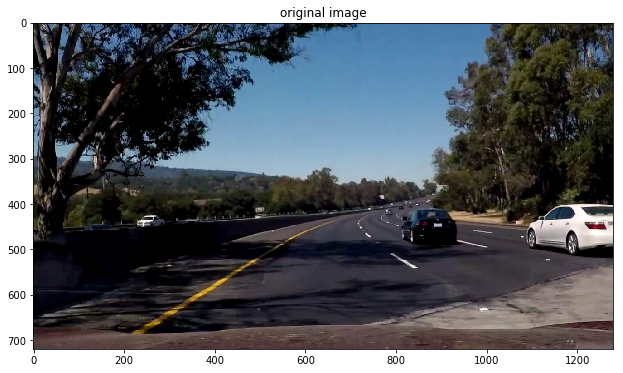

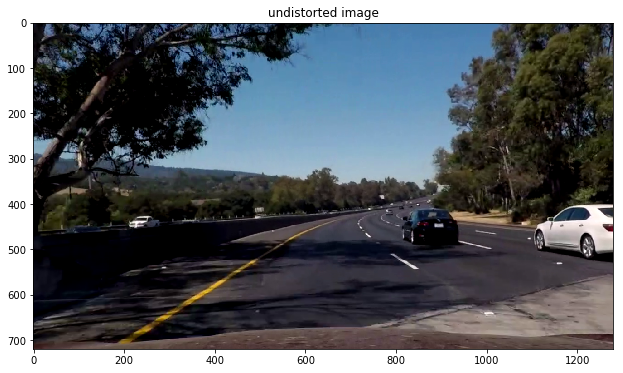

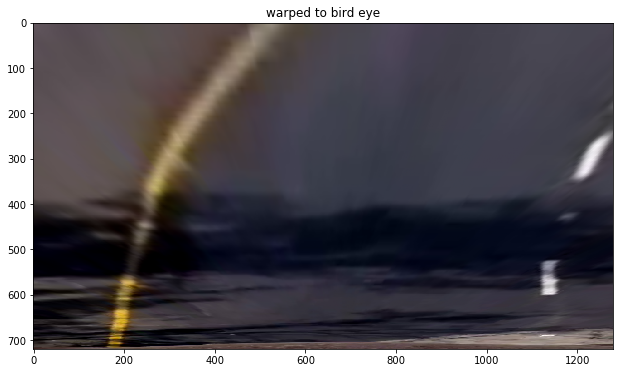

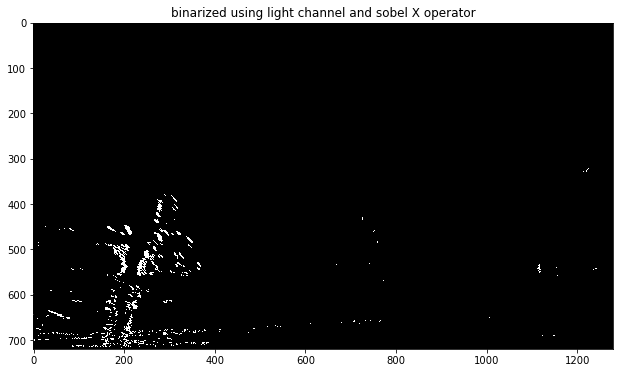

r_conv_signal=6700.0
l_conv_signal=197800.0
slicing from 560 to 640.
conv_left=40679.0, conv_right=100.0, level=1
slicing from 480 to 560.
conv_left=101572.0, conv_right=4001.0, level=2
slicing from 400 to 480.
conv_left=46451.0, conv_right=0.0, level=3
slicing from 320 to 400.
conv_left=6250.0, conv_right=481.0, level=4
slicing from 240 to 320.
conv_left=0.0, conv_right=0.0, level=5
slicing from 160 to 240.
conv_left=0.0, conv_right=0.0, level=6
slicing from 80 to 160.
conv_left=0.0, conv_right=0.0, level=7
slicing from 0 to 80.
conv_left=0.0, conv_right=0.0, level=8


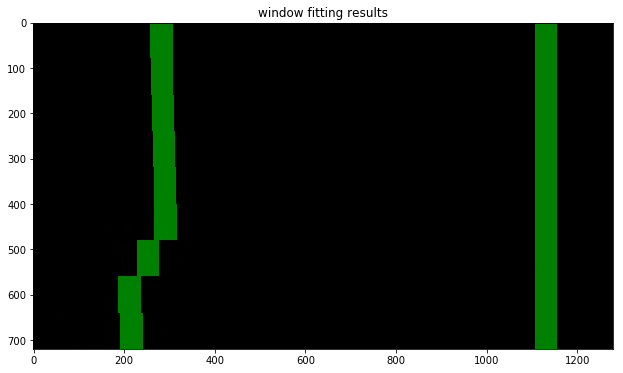

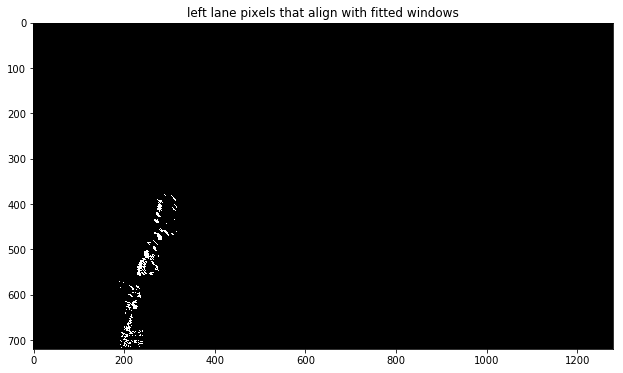

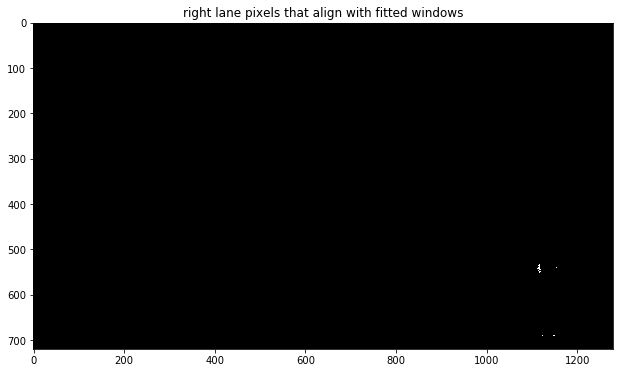

361.1m, 1201.5m


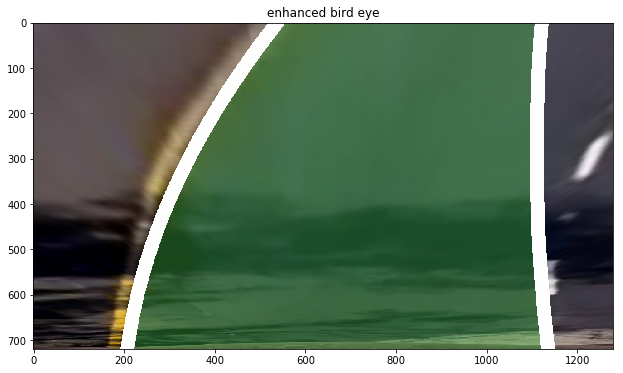

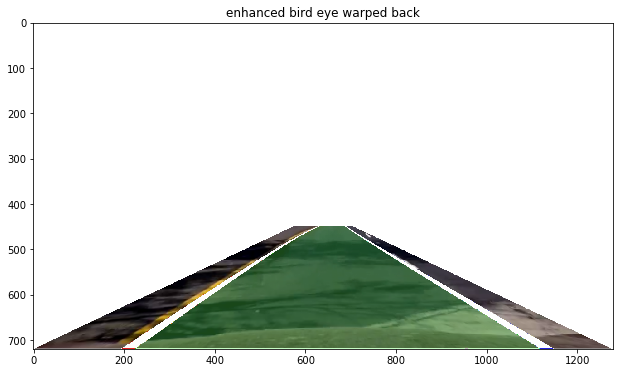

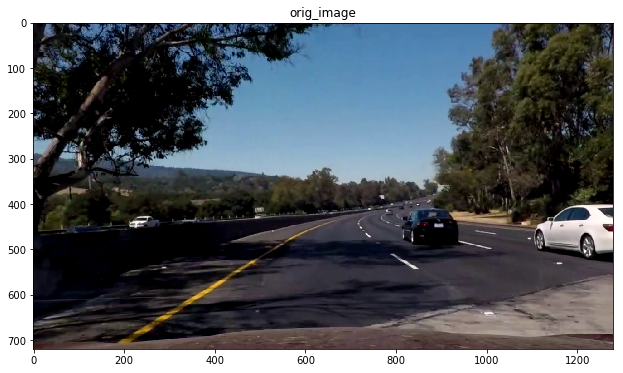

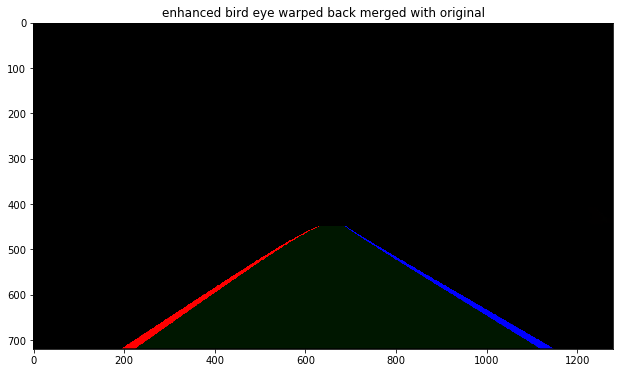

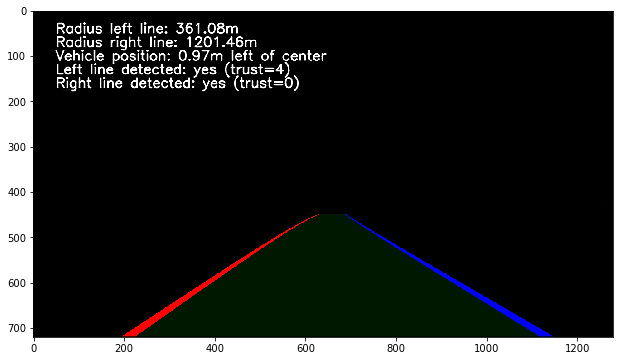

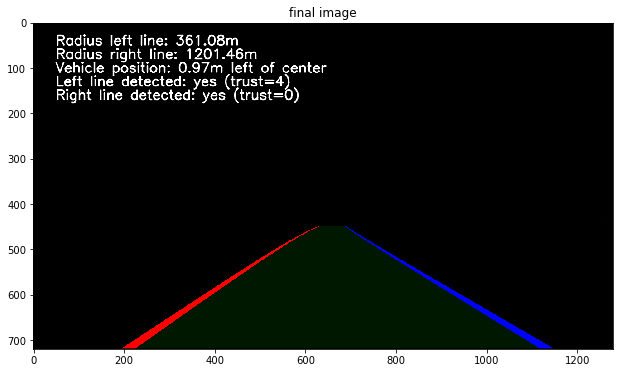

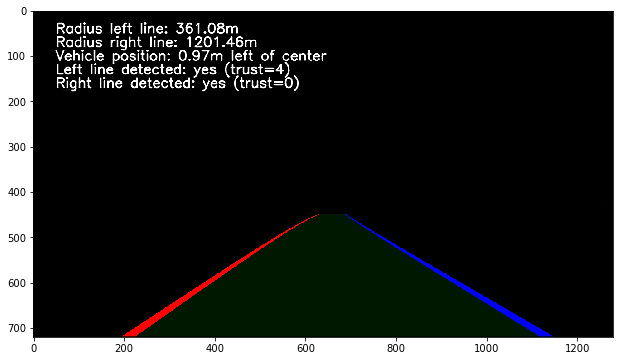

In [19]:
def process_image(img, video_mode = False):
    global left_line
    global right_line
    
    if not video_mode:
        plt.imshow(img)
        plt.title("original image")
        plt.show()

    undistorted = ud(img)
    if not video_mode:
        plt.imshow(undistorted)
        plt.title("undistorted image")
        plt.show()

    warped = warp(undistorted)
    if not video_mode:
        plt.imshow(warped, cmap="gray")
        plt.title("warped to bird eye")
        plt.show()

    # orig s_thresh=(170, 255), sx_thresh=(20, 100))
    binary_warped = threshold(warped, s_thresh=(170, 255), sx_thresh=(20, 200))
    if not video_mode:
        plt.imshow(binary_warped, cmap="gray")
        plt.title("binarized using light channel and sobel X operator")
        plt.show()

    assembled_image = work_image(binary_warped, warped, undistorted, video_mode)
    if not video_mode:
        plt.imshow(assembled_image)
        plt.title("final image")
        plt.show()
        
    return assembled_image

img = mpimg.imread("stress_images/vlcsnap-2017-09-29-09h04m55s971.png")
ai = process_image(img, video_mode=False)
plt.imshow(ai)
plt.show()

In [20]:
right_line.get_averaged_fit()

array([  1.36735704e-04,  -7.85482453e-02,   1.12263656e+03])

complete pipeline, executed a single time

# Videos

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def prcs(img):
    return process_image(img, video_mode=True)

In [23]:
read_input = "challenge_video.mp4"
white_output = 'output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(read_input)
white_clip = clip1.fl_image(prcs) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output/challenge_video.mp4
[MoviePy] Writing video output/challenge_video.mp4


 58%|██████████████████████████████████████████████▎                                 | 281/485 [01:32<01:07,  3.03it/s]

[371 372 373 386 371 372 373 371 372 373 371 372 373 374 377 384 371 372
 373 374 377 384 372 373 374 372 373 374 375 378 379 384 373 374 375 377
 379 385 373 374 375 376 377 378 385 373 374 375 376 377 378 386 373 374
 375 376 377 379 374 375 376 380 382 383 374 375 376 377 378 386 387 374
 375 376 377 379 381 382 387 388 375 376 377 378 379 380 382 385 387 388
 390 375 376 377 378 380 381 383 388 390 376 377 378 380 381 387 390 391
 376 377 378 381 382 384 387 388 389 390 391 376 377 378 379 380 382 383
 385 388 389 390 391 376 377 378 379 380 381 383 384 385 388 389 390 391
 376 377 378 379 380 381 382 384 385 388 389 390 391 377 378 379 380 381
 382 385 386 388 389 390 391 392 377 378 379 380 381 382 383 385 386 388
 389 390 391 392 378 379 380 381 382 383 384 385 387 388 389 390 391 392
 378 379 381 382 383 384 385 387 388 390 391 392 393 378 379 381 382 383
 384 385 386 388 389 390 391 392 393 379 380 381 383 384 385 388 389 391
 392 393 394 379 380 381 382 389 392 393 380 381 38

100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [02:39<00:00,  3.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/challenge_video.mp4 

Wall time: 2min 39s
